In [1]:
import pickle
import scipy.stats
import os
import sys
import random
import torch
import numpy as np
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
from collections import defaultdict
from visualisation_utils import VisualisationUtils
sys.path.append("../src")
from data import preprocess_dataset

utils = VisualisationUtils()
sns.set_context("talk")
sns.set_style("white")

In [2]:
def get_events(l1, l2, l3, d1, d2, nd, modeln, dataset, seeds=[]):
    maxi = 1 if "v2" in dataset or "1.3" in modeln else 3
    assert len(l1) % maxi == 0
    assert len(l2) % maxi == 0
    assert len(l3) % maxi == 0
    seeds1 = [s for s in range(1, maxi + 1) for i in range(int(len(l1)/maxi))]
    seeds2 = [s for s in range(1, maxi + 1) for i in range(int(len(l2)/maxi))]
    seeds3 = [s for s in range(1, maxi + 1) for i in range(int(len(l3)/maxi))]

    crossings = []
    inits = []
    
    for seed in range(1, maxi + 1) if not seeds else seeds:
        prev_d = 100
        crossing = None
        for l in range(24 if "1.3" in modeln else 12):
            d = np.mean([d_ for l_, d_, s_ in zip(l3, nd, seeds3) if l_ == l and s_ == seed])
            if prev_d > 0.5 and d < 0.5:
                crossing = l
            prev_d = d

        init = None
        for l in range(24 if "1.3" in modeln else 12):
            d = [d_ for l_, d_, s_ in zip(l1, d1, seeds1) if l_ == l and s_ == seed]
            p1 = np.percentile(d, [87.5][0])
            d = [d_ for l_, d_, s_ in zip(l2, d2, seeds2) if l_ == l and s_ == seed]
            p2 = np.percentile(d, [12.5][0])
            if init is None and p1 < p2:
                init = l
            if p1 > p2:
                init = None
                
        crossings.append(crossing + 1)
        inits.append(init + 1)
    return np.mean(crossings), np.mean(inits)

In [3]:
def visualise_centroid_analysis(ds_names, model_setups, postfix="", big=False):
    for dataset in ds_names:
        for modeln, model in model_setups:
            filename = f"../results/centroid_analysis/{dataset}/{model}{postfix}.pickle"
            if not os.path.exists(filename):
                print(filename)
                continue
            [c1, c2, c3] = sns.color_palette("viridis", 3)
            if dataset == "mrpc" and not "1.3" in modeln:
                layers, distances = pickle.load(open(filename, 'rb'))
                l = layers["class1"]
                l2 = layers["class2"]
                l3 = layers["noisy"]
                d1 = distances["class1"]
                d2 = distances["class2"]
                nd = distances["noisy"]
            else:
                l, l2, l3, d1, d2, nd = pickle.load(open(filename, 'rb'))

            f = plt.figure(figsize=(6, 2))
            # Plot the 1D projection
            sns.set_context("talk")
            ax = sns.lineplot(
                    x=l + l2,
                    y=d1 + d2, alpha=.99, linewidth=5,
                    hue=["classa"]*len(d1)+["classb"]*len(d2), errorbar=('pi', 75), palette=[c2, c3])

            sns.lineplot(
                    x=l3,
                    y=nd, alpha=.99, linewidth=4,
                    hue=["memorised examples"]*len(nd), errorbar=('pi', 75), palette=['midnightblue'])
            plt.ylim(-5, 5)
            sns.lineplot(x=[0, 12 if not big else 24], y=[.5, .5], color='black', linestyle='--')
            plt.xticks(range(0, 12 if not big else 24, 1 if not big else 2),
                       range(1, 13 if not big else 25, 1 if not big else 2),
                       fontsize=17)
            plt.xlim(0, 11 if not big else 23)
            plt.ylim(-0.008, 1.01)
            plt.yticks([])
            #plt.xlabel("layer")
            plt.grid(zorder=-1)
            plt.legend([],[],frameon=False)
            sns.despine(top=True, right=True, bottom=True)
            plt.savefig(f"centroid_analysis/{dataset}_{modeln}{postfix}.pdf", bbox_inches="tight")
            plt.show()


def summarise_events(ds_names, model_setups, postfix="", plot=False):
    results = defaultdict(lambda: dict())
    x, y, d = [], [], []
    allx, ally, alld = [], [], []
    for dataset in ds_names:
        x_, y_ = [], []
        for modeln, model in model_setups:
            filename = f"../results/centroid_analysis/{dataset}/{model}{postfix}.pickle"
            if not os.path.exists(filename):
                print(filename)
                continue
            [c1, c2, c3] = sns.color_palette("viridis", 3)
            if dataset != "mrpc" or postfix or "1.3" in modeln:
                l, l2, l3, d1, d2, nd = pickle.load(open(filename, 'rb'))
                crossing, init = get_events(l, l2, l3, d1, d2, nd, modeln, dataset)
            else:
                layers, distances = pickle.load(open(filename, 'rb'))
                crossing, init = get_events(layers["class1"], layers["class2"], layers["noisy"],
                                            distances["class1"], distances["class2"], distances["noisy"], modeln, dataset)
            x_.append(crossing)
            y_.append(init)
            allx.append(crossing)
            ally.append(init)
            alld.append(dataset)
            results[modeln][dataset] = (crossing, init)
        if x_:
            x.append(np.mean(x_))
            y.append(np.mean(y_))
            d.append(dataset)
    return x, y, d, allx, ally, alld, dict(results)

#### Section 5: Figure 12, crossing / initiation events

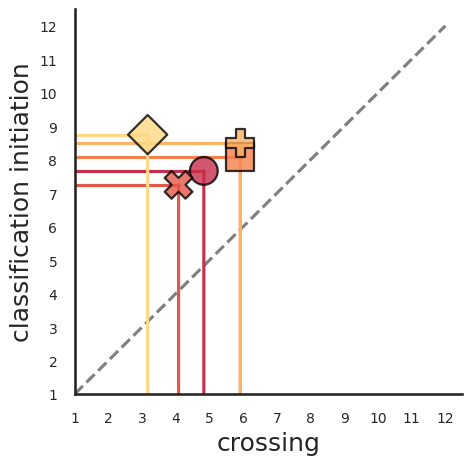

In [5]:
x, y, d, allx, ally, alld, results = summarise_events(utils.ds_names, utils.model_setups)
utils.visualise_events(x, y, d, "centroid_analysis/all_events_centroid.pdf")
pickle.dump(results, open("pickled_results/centroid_events.pickle", 'wb'))

#### Appendix A.3: Figure 15, regular centroid analysis

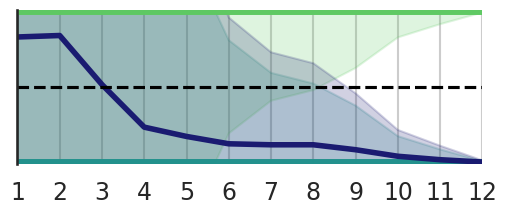

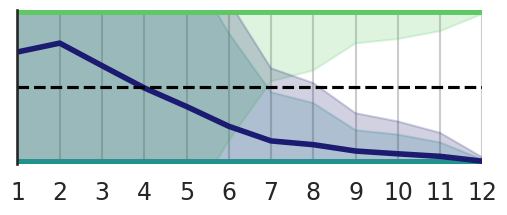

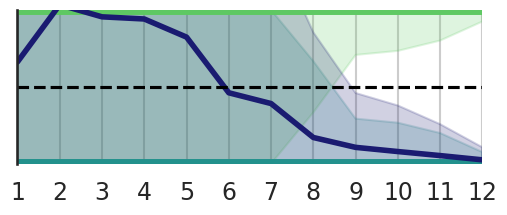

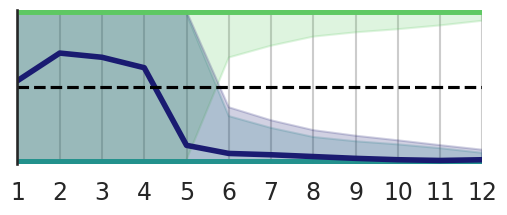

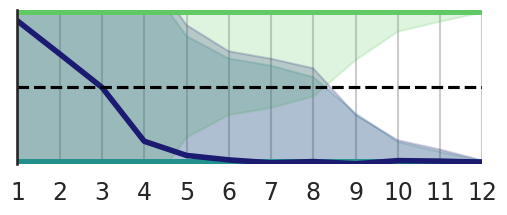

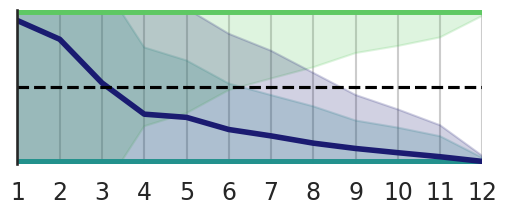

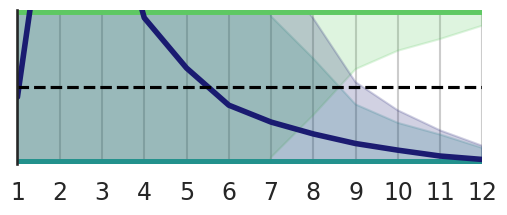

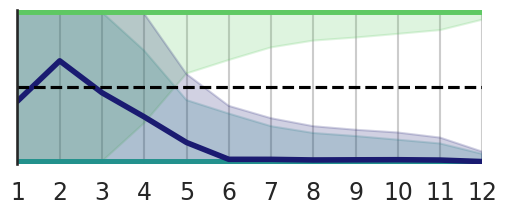

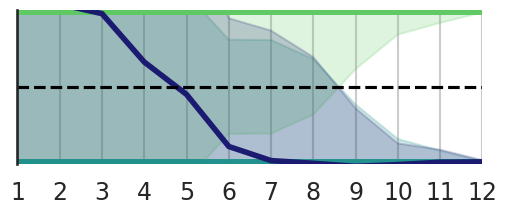

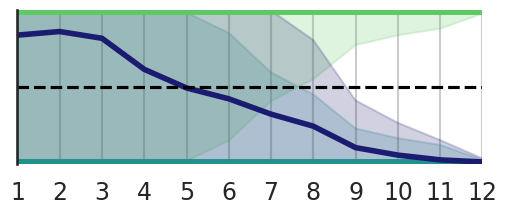

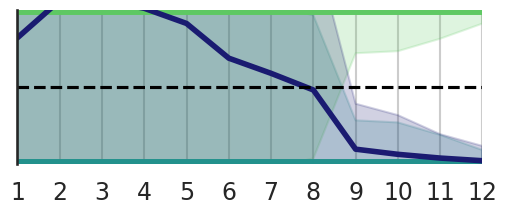

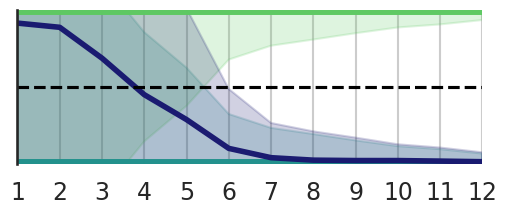

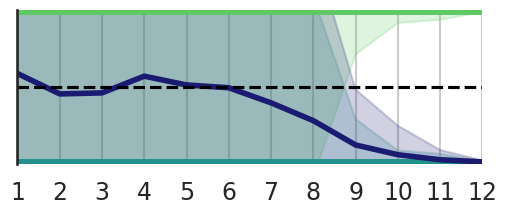

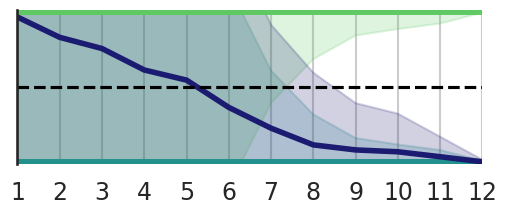

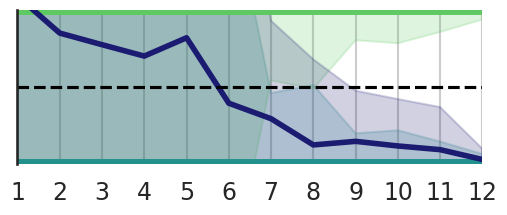

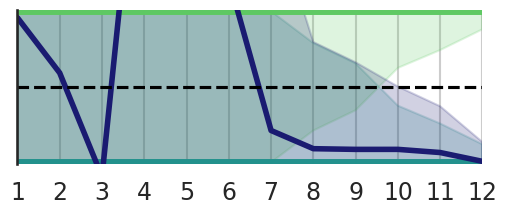

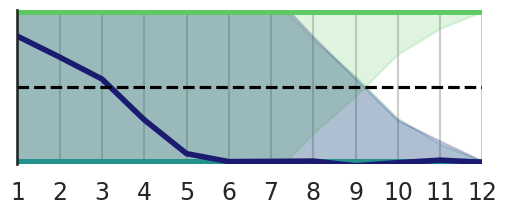

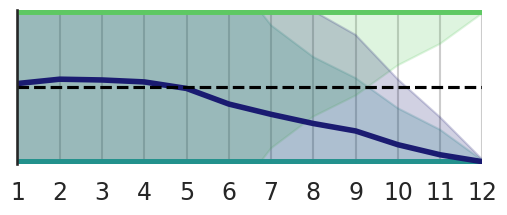

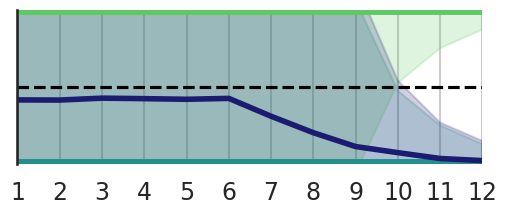

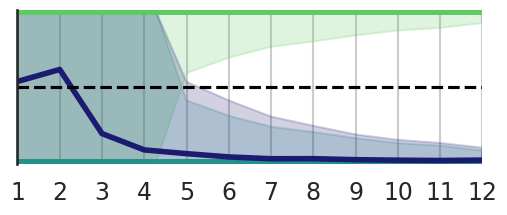

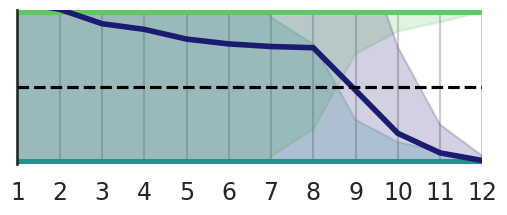

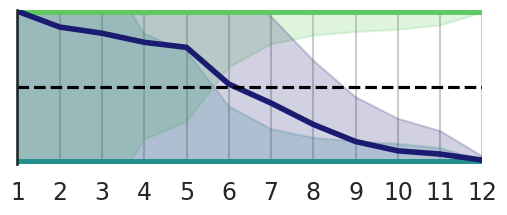

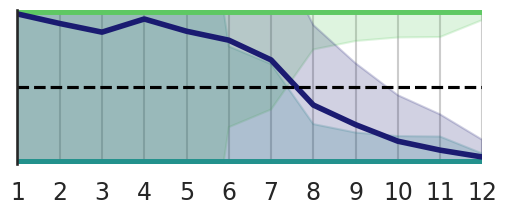

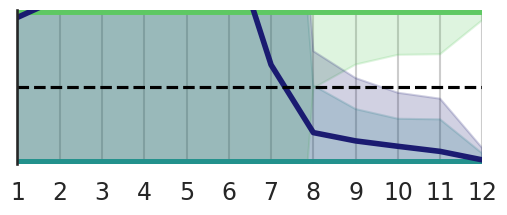

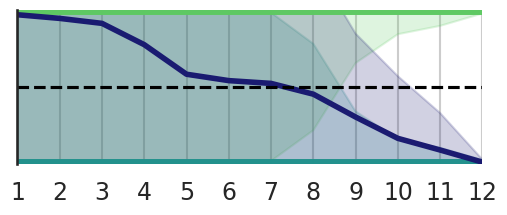

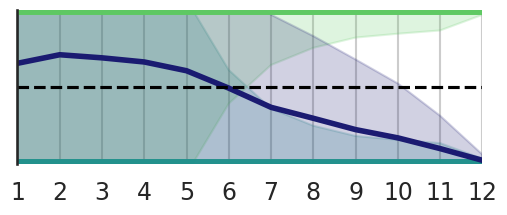

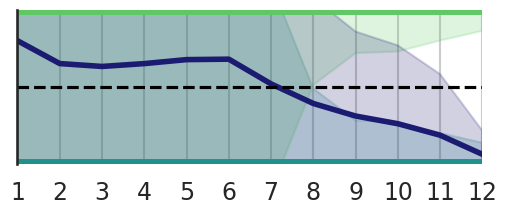

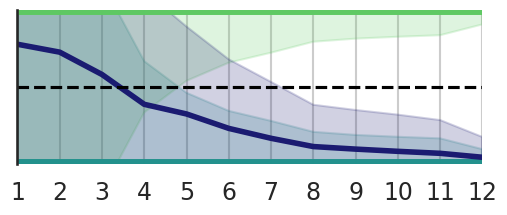

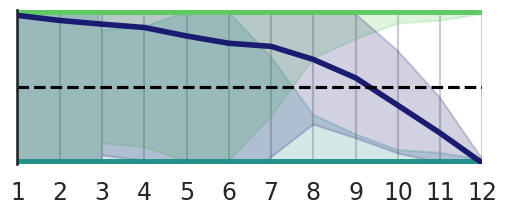

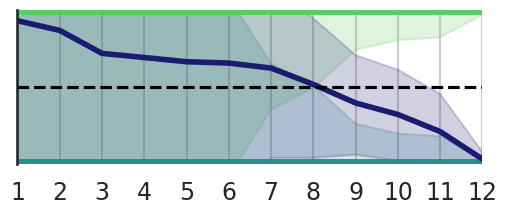

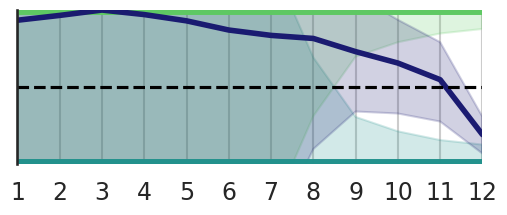

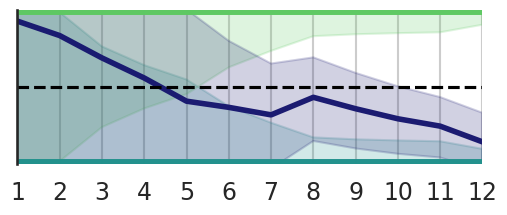

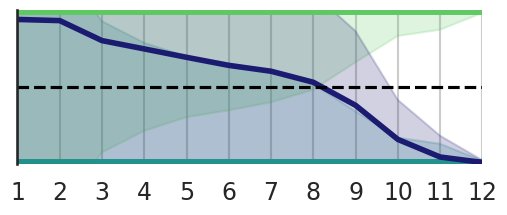

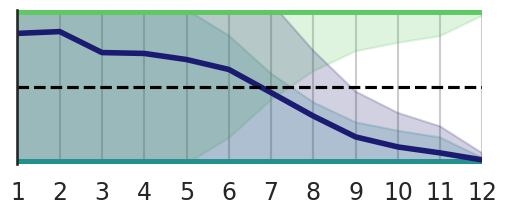

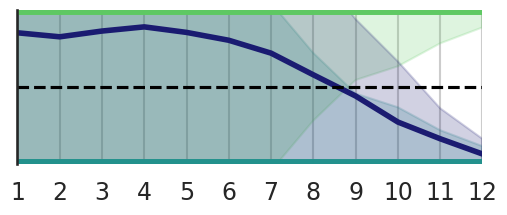

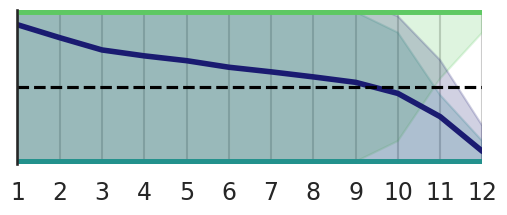

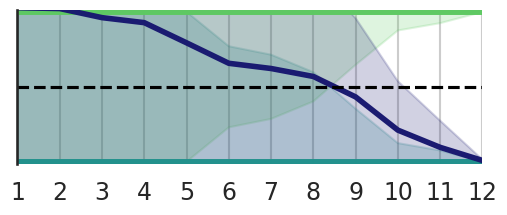

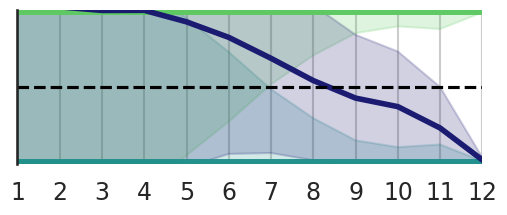

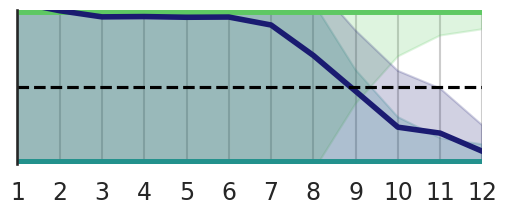

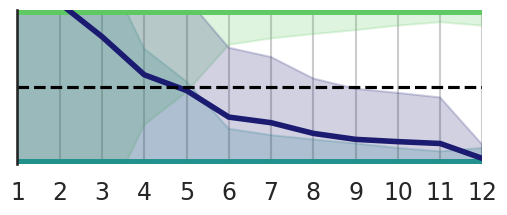

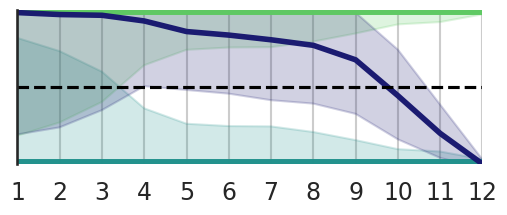

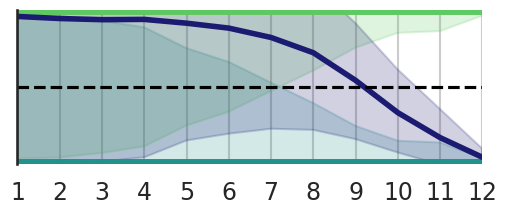

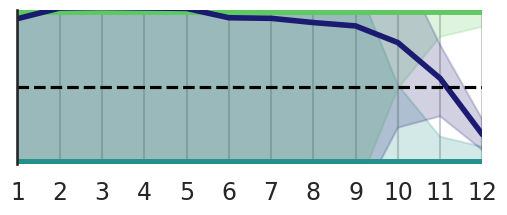

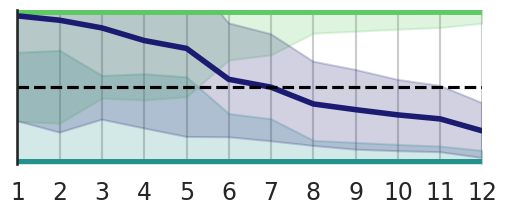

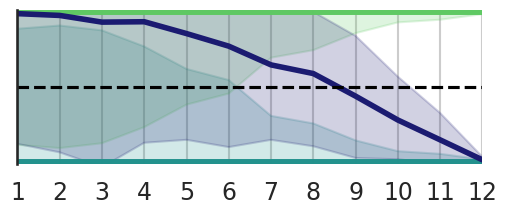

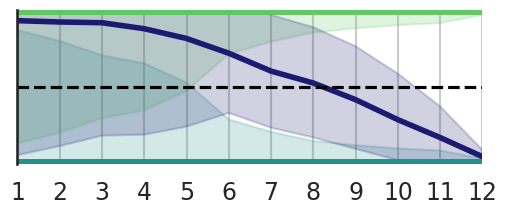

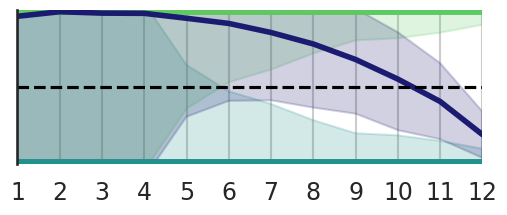

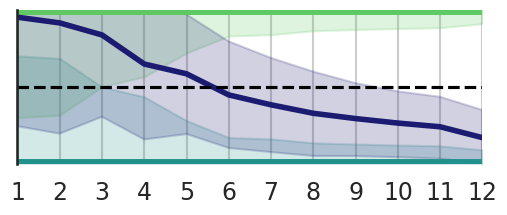

In [12]:
visualise_centroid_analysis(
    utils.ds_names, utils.model_setups, postfix="", big=False)

#### Appendix A.3: Figure 15, replacing the bottom or the top half of the model, for OPT

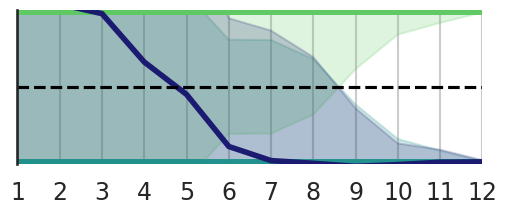

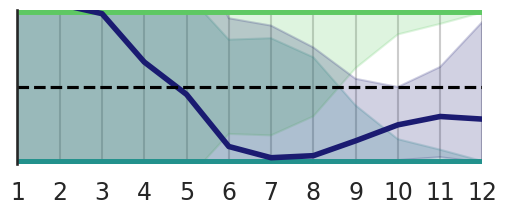

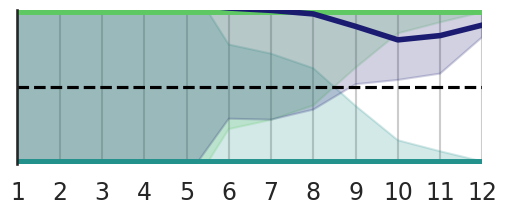

In [29]:
visualise_centroid_analysis(
    ["mrpc"], [("BERT", "bert-base-cased")], postfix="", big=False)
visualise_centroid_analysis(
    ["mrpc"], [("BERT", "bert-base-cased")], postfix="_mixb", big=False)
visualise_centroid_analysis(
    ["mrpc"], [("BERT", "bert-base-cased")], postfix="_mixt", big=False)

### Appendix B: Increasing model size

#### Figure 17 classification / initiation events for OPT-big

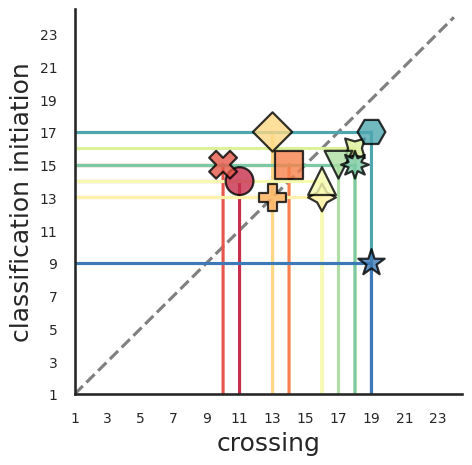

In [12]:
x_b, y_b, d_b, _, _, _, results = summarise_events(utils.ds_names, [("OPT-1.3B", "facebook_opt-1.3b")])
utils.visualise_events(x_b, y_b, d_b, "centroid_analysis/events_big.pdf", big=True)

In [13]:
rx, px = scipy.stats.spearmanr(x, x_b)
ry, py = scipy.stats.spearmanr(y, y_b)
print(f"{rx:.2f} {px:.2f} {ry:.2f} {py:.2f}")

0.94 0.00 0.15 0.64


### Appendix C: binarisation of tasks

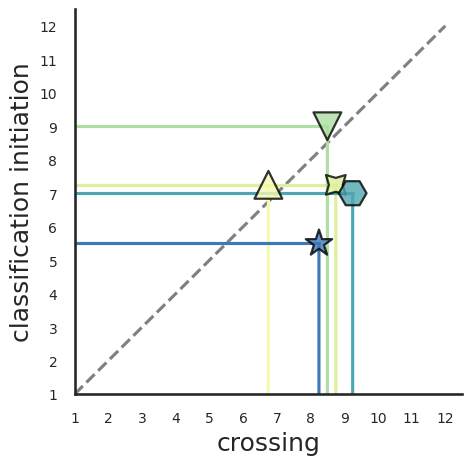

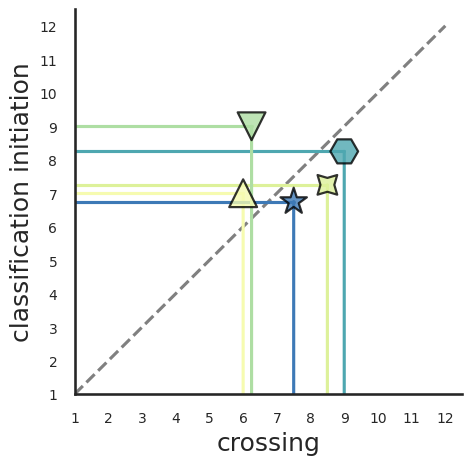

Mem. diff: -0.85, class. init. diff: 0.45
Mem. correlation: rho = 0.90, p = 0.04
Classification init. correlation: rho = 0.67, p = 0.22


In [4]:
def visualise_v2(ds_names, models, filename, seeds):
    x, y, d = [], [], []
    for dataset in ds_names:
        x_, y_ = [], []
        for modeln, model in models:
            fn = f"../results/centroid_analysis/{dataset}/{model}.pickle"
            l, l2, l3, d1, d2, nd = pickle.load(open(fn, 'rb'))
            crossing, init = get_events(l, l2, l3, d1, d2, nd, modeln, dataset, seeds=seeds)
            x_.append(crossing)
            y_.append(init)

        x.append(np.mean(x_))
        y.append(np.mean(y_))
        d.append(dataset)
    utils.visualise_events(x, y, d, filename=filename)
    return x, y


x1, y1 = visualise_v2(
    ['sst5', 'emotion', 'trec', 'reuters', 'implicithate'],
    utils.model_setups,
    "centroid_analysis/eventsv1.pdf",
    seeds=[1])
x2, y2 = visualise_v2(
    ['sst5v2', 'emotionv2', 'trecv2', 'reutersv2', 'implicithatev2'],
    utils.model_setups,
    "centroid_analysis/eventsv2.pdf",
    seeds=[1])

print(f"Mem. diff: {np.mean(x2) - np.mean(x1):.2f}, class. init. diff: {np.mean(y2) - np.mean(y1):.2f}")
r, p = scipy.stats.spearmanr(x1, x2)
print(f"Mem. correlation: rho = {r:.2f}, p = {p:.2f}")
r, p = scipy.stats.spearmanr(y1, y2)
print(f"Classification init. correlation: rho = {r:.2f}, p = {p:.2f}")

### Section 5: paragraph on the memorisation/generalisation relation

In [6]:
centroid_results = pickle.load(open("pickled_results/centroid_events.pickle", 'rb'))
probing = pickle.load(open("pickled_results/probing_events.pickle", 'rb'))
mcog = pickle.load(open("pickled_results/mcog_summary.pickle", 'rb'))

In [7]:
stats, genscores, validationscores = pickle.load(open("memcor_data.pickle", 'rb'))
validationscores_norm = defaultdict(lambda: dict())
for m in validationscores:
    for d in validationscores[m]:
        validationscores_norm[m][d] = (validationscores[m][d] - stats[d]["random_performance"]) / \
            (1 - stats[d]["random_performance"])

for scores in [genscores, validationscores_norm]:
    rs_pr = []
    rs_ca = []
    rs_mcog = []
    for model in ["all"] + list(probing.keys()):
        print(model)
        if model == "all":
            mem_pr  = [probing[model][d][0] for model in probing for d in utils.ds_names]
            mem_ca = [centroid_results[model][d][0] for model in probing  for d in utils.ds_names]
            mem_mcog = [mcog[model][d] for model in probing  for d in utils.ds_names]
            scores_overall = [scores[m][d] for m in probing for d in utils.ds_names]
            r_pr, p_pr = scipy.stats.spearmanr(mem_pr, scores_overall)
            r_ca, p_ca = scipy.stats.spearmanr(mem_ca, scores_overall)
            r_mcog, p_mcog = scipy.stats.spearmanr(mem_mcog,scores_overall )
        else:
            mem_pr = [probing[model][d][0] for d in utils.ds_names]
            mem_ca = [centroid_results[model][d][0] for d in utils.ds_names]
            mem_mcog = [mcog[model][d] for d in utils.ds_names]
            scores_per_dataset = [scores[model][d] for d in utils.ds_names]
            r_pr, p_pr = scipy.stats.spearmanr(mem_pr, scores_per_dataset)
            r_ca, p_ca = scipy.stats.spearmanr(mem_ca, scores_per_dataset)
            r_mcog, p_mcog = scipy.stats.spearmanr(mem_mcog, scores_per_dataset)
        rs_pr.append(f"{r_pr:.2f}/{p_pr:.2f}")
        rs_ca.append(f"{r_ca:.2f}/{p_ca:.2f}")
        rs_mcog.append(f"{r_mcog:.2f}/{p_mcog:.2f}")
    print(' & '.join(rs_ca))
    print(' & '.join(rs_pr))    
    print(' & '.join(rs_mcog))    


all
BERT
OPT
GPT-N
Pythia
0.75/0.00 & 0.88/0.00 & 0.94/0.00 & 0.94/0.00 & 0.72/0.01
0.63/0.00 & 0.86/0.00 & 0.88/0.00 & 0.94/0.00 & 0.69/0.01
0.56/0.00 & 0.78/0.00 & 0.69/0.01 & 0.92/0.00 & 0.69/0.01
all
BERT
OPT
GPT-N
Pythia
0.70/0.00 & 0.90/0.00 & 0.84/0.00 & 0.83/0.00 & 0.70/0.01
0.61/0.00 & 0.90/0.00 & 0.77/0.00 & 0.76/0.00 & 0.77/0.00
0.54/0.00 & 0.80/0.00 & 0.52/0.08 & 0.72/0.01 & 0.69/0.01
